## With Google Gemini Pro

In [1]:
# !pip install -q -U google-generativeai

In [2]:
# Necessary packages
import pathlib
import textwrap
import pandas as pd
import os

import google.generativeai as genai

from IPython.display import display
from IPython.display import Markdown

In [ ]:
def to_markdown(text):
  text = text.replace('•', '  *')
  return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

In [ ]:
GOOGLE_API_KEY=os.getenv('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)

In [ ]:
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

In [ ]:
model = genai.GenerativeModel('gemini-pro')

In [ ]:
%%time
response = model.generate_content("What is the meaning of life?")

to_markdown(response.text)

In [18]:
test_set = pd.read_csv("test_data.csv")
train_set = pd.read_csv("train_data.csv")

In [ ]:
test_set_sample = test_set.sample(20)

test_set_sample['pred_label'] = ''

test_set_sample

In [ ]:
# Convert the DataFrame to JSON using the to_json() method
json_data = test_set_sample[['clean_reviews','pred_label']].to_json(orient='records')

# Print the JSON data
print(json_data)

In [ ]:
prompt = f"""
You are an expert linguist, who is good at classifying presidential election tweet sentiments into Positive/Negative labels.
Help me classify presidential election tweets into: Positive(label=1), and Negative(label=0).
Tweets are provided between three back ticks.
In your output, only return the Json code back as output - which is provided between three backticks.
Your task is to update predicted labels under 'pred_label' in the Json code.
Don't make any changes to Json code format, please.

```
{json_data}
```
"""

print(prompt)

In [ ]:
response = model.generate_content(prompt)

print(response.text)

In [ ]:
import json

# Clean the data by stripping the backticks
json_data = response.text.strip("`")

# Load the cleaned data and convert to DataFrame
data = json.loads(json_data)
df_sample = pd.DataFrame(data)

df_sample

In [ ]:
# Overwrite pred_label from 'df' into pred_label in 'train_set_sample'
test_set_sample['pred_label'] = df_sample['pred_label'].values

test_set_sample

In [ ]:
# Plotting confusion matrix on the predictions

from sklearn.metrics import confusion_matrix

y_true = test_set_sample["label"]
y_pred = test_set_sample["pred_label"]

confusion_matrix(y_true, y_pred)

## Batching API Calls: Gemini API

In [ ]:
test_set.shape

In [ ]:
test_set_total = test_set.sample(100)

test_set_total['pred_label'] = ''

test_set_total

In [ ]:
batches = []
batch_size = 25

for i in range(0, len(test_set_total), batch_size):
  batches.append(test_set_total[i : i + batch_size])  # Append batches instead of assigning

In [ ]:
import time

def gemini_completion_function(batch,current_batch,total_batch):
  """Function works in three steps:
  # Step-1: Convert the DataFrame to JSON using the to_json() method.
  # Step-2: Preparing the Gemini Prompt
  # Step-3: Calling Gemini API
  """

  print(f"Now processing batch#: {current_batch+1} of {total_batch}")

  json_data = batch[['clean_reviews','pred_label']].to_json(orient='records')

  prompt = f"""
  You are an expert linguist, who is good at classifying presidential election tweet sentiments into Positive/Negative labels.
  Help me classify presidential election tweets into: Positive(label=1), and Negative(label=0).
  Tweets are provided between three back ticks.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'pred_label' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).

  ```
  {json_data}
  ```
  """

  print(prompt)
  response = model.generate_content(prompt)
  time.sleep(5)

  return response

In [ ]:
batch_count = len(batches)
responses = []

for i in range(0,len(batches)):
  responses.append(gemini_completion_function(batches[i],i,batch_count))

In [ ]:
import json

df_total = pd.DataFrame()  # Initialize an empty DataFrame

for response in responses:
  # Clean the data by stripping the backticks
  json_data = response.text.strip("`")

  # Load the cleaned data and convert to DataFrame
  data = json.loads(json_data)
  df_temp = pd.DataFrame(data)

  # Append the DataFrame to the final DataFrame
  df_total = df_total.append(df_temp, ignore_index=True)

print(df_total)  # Display the final DataFrame

In [ ]:
# Overwrite pred_label from 'df' into pred_label in 'train_set_sample'

test_set_total['pred_label'] = df_total['pred_label'].values
test_set_total

In [ ]:
# Plotting confusion matrix on the predictions

from sklearn.metrics import confusion_matrix

y_true = test_set_total["label"]
y_pred = test_set_total["pred_label"]

confusion_matrix(y_true, y_pred)

## With OpenAI GPT model

In [3]:
# !pip install openai==0.27.0

In [13]:
import openai

# OPENAI_API_KEY=os.getenv('OPENAI_API_KEY')
OPENAI_API_KEY=''
openai.api_key  = OPENAI_API_KEY

In [14]:
def get_completion(prompt, model="gpt-3.5-turbo-1106"):

  messages = [{"role": "user", "content": prompt}]
  response = openai.ChatCompletion.create(model=model,messages=messages,temperature=0)

  return response.choices[0].message["content"]

In [15]:
prompt = "Why is the sky blue?"

chatgpt_response = get_completion(prompt)

In [16]:
chatgpt_response

"The sky appears blue to our eyes because of the way the Earth's atmosphere scatters sunlight. The shorter blue wavelengths of light are scattered more than the other colors in the spectrum, such as red and yellow, by the gases and particles in the atmosphere. This scattering causes the blue light to be more visible, giving the sky its blue color."

### Batching API Calls (Single Shot)

In [20]:
test_set_total = test_set

test_set_total['pred_label'] = ''

test_set_total

,tweet,label,clean_tweets,pred_label
0,Anura kumara dissanayake backed up from #China...,1,anura kumara dissanayake backed up from china ...,
1,Anura Kumara Dissanayake in London expressed r...,0,anura kumara dissanayake in london expressed r...,
2,"Voting RW means letting SP win, it’s simple as...",1,voting rw means letting sp win it simple as th...,
3,So JVP PM is Gona be tilvin? What a disaster i...,0,so jvp pm is gona be tilvin what disaster it w...,
4,"Anura Kumara Dissanayake, Wasantha Samarasingh...",0,anura kumara dissanayake wasantha samarasinghe...,
5,We’ve had our fair share of debates and argume...,0,we ve had our fair share of debates and argume...,
6,Compared to SJBs economy policy surely NPP doe...,0,compared to sjbs economy policy surely npp doe...,
7,AK Dissanayake (NPP) is projected to win the u...,1,ak dissanayake npp is projected to win the upc...,
8,"The JVP, including Anura Kumara Dissanayake, r...",0,the jvp including anura kumara dissanayake res...,
9,We had a good past.\nDon't get fooled by AKD's...,0,we had good past don get fooled by akd words h...,


In [21]:
batches = []
batch_size = 50

for i in range(0, len(test_set_total), batch_size):
  batches.append(test_set_total[i : i + batch_size])  # Append batches instead of assigning

In [24]:
import time

def gpt_completion_function(batch,current_batch,total_batch,model="gpt-3.5-turbo-1106"):
  """Function works in three steps:
  # Step-1: Convert the DataFrame to JSON using the to_json() method.
  # Step-2: Preparing Prompt
  # Step-3: Calling GPT API
  """

  print(f"Now processing batch#: {current_batch+1} of {total_batch}")

  json_data = batch[['clean_tweets','pred_label']].to_json(orient='records')

  prompt = f"""
  You are an expert linguist, who is good at classifying presidential election tweet sentiments into Positive/Negative labels.
  Help me classify presidential election tweets into: Positive(label=1), and Negative(label=0).
  Tweets are provided between three back ticks.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'pred_label' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).

  ```
  {json_data}
  ```
  """

  print(prompt)

  messages = [{"role": "user", "content": prompt}]
  response = openai.ChatCompletion.create(model=model,messages=messages,temperature=0)
  time.sleep(5)
  return response.choices[0].message["content"]

In [25]:
batch_count = len(batches)
responses = []

for i in range(0,len(batches)):
  responses.append(gpt_completion_function(batches[i],i,batch_count))

Now processing batch#: 1 of 1

  You are an expert linguist, who is good at classifying presidential election tweet sentiments into Positive/Negative labels.
  Help me classify presidential election tweets into: Positive(label=1), and Negative(label=0).
  Tweets are provided between three back ticks.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'pred_label' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).

  ```
  [{"clean_tweets":"anura kumara dissanayake backed up from china chinese are pushing anura kumara on socialmedia reactions have been around for long time","pred_label":""},{"clean_tweets":"anura kumara dissanayake in london expressed regret over the killings for which jvp was responsible sunday observer 1 jun 2014 th

In [28]:
import json
import pandas as pd

df_total = pd.DataFrame()  # Initialize an empty DataFrame

for response in responses:
    # Clean the data by stripping the backticks
    json_data = response.strip("`")
    
    # Load the cleaned data and convert to DataFrame
    data = json.loads(json_data)
    df_temp = pd.DataFrame(data)
    
    # Append the DataFrame to the final DataFrame using pd.concat()
    df_total = pd.concat([df_total, df_temp], ignore_index=True)

print(df_total)  # Display the final DataFrame

                                         clean_tweets  pred_label
0   anura kumara dissanayake backed up from china ...           0
1   anura kumara dissanayake in london expressed r...           0
2   voting rw means letting sp win it simple as th...           1
3   so jvp pm is gona be tilvin what disaster it w...           0
4   anura kumara dissanayake wasantha samarasinghe...           0
5   we ve had our fair share of debates and argume...           0
6   compared to sjbs economy policy surely npp doe...           0
7   ak dissanayake npp is projected to win the upc...           1
8   the jvp including anura kumara dissanayake res...           0
9   we had good past don get fooled by akd words h...           0
10  would like to ask anura kumara dissanayake who...           0
11  for anyone new to srilanka politics and intere...           1
12  big shifts in voting intent in the first half ...           0
13  npp government is ready to bring in foreign in...           1
14  as pre

In [29]:
# Overwrite pred_label from 'df' into pred_label in 'train_set_sample'

test_set_total['pred_label'] = df_total['pred_label'].values
test_set_total

,tweet,label,clean_tweets,pred_label
0,Anura kumara dissanayake backed up from #China...,1,anura kumara dissanayake backed up from china ...,0
1,Anura Kumara Dissanayake in London expressed r...,0,anura kumara dissanayake in london expressed r...,0
2,"Voting RW means letting SP win, it’s simple as...",1,voting rw means letting sp win it simple as th...,1
3,So JVP PM is Gona be tilvin? What a disaster i...,0,so jvp pm is gona be tilvin what disaster it w...,0
4,"Anura Kumara Dissanayake, Wasantha Samarasingh...",0,anura kumara dissanayake wasantha samarasinghe...,0
5,We’ve had our fair share of debates and argume...,0,we ve had our fair share of debates and argume...,0
6,Compared to SJBs economy policy surely NPP doe...,0,compared to sjbs economy policy surely npp doe...,0
7,AK Dissanayake (NPP) is projected to win the u...,1,ak dissanayake npp is projected to win the upc...,1
8,"The JVP, including Anura Kumara Dissanayake, r...",0,the jvp including anura kumara dissanayake res...,0
9,We had a good past.\nDon't get fooled by AKD's...,0,we had good past don get fooled by akd words h...,0


In [30]:
# Plotting confusion matrix on the predictions

from sklearn.metrics import confusion_matrix, accuracy_score

y_true = test_set_total["label"]
y_pred = test_set_total["pred_label"]

print(confusion_matrix(y_true, y_pred))
print(f"\nAccuracy: {accuracy_score(y_true, y_pred)}")

[[10  0]
 [ 1  4]]

Accuracy: 0.9333333333333333


### Batching API Calls (Few Shot)

In [31]:
test_set_total = test_set

test_set_total['pred_label'] = ''

test_set_total

,tweet,label,clean_tweets,pred_label
0,Anura kumara dissanayake backed up from #China...,1,anura kumara dissanayake backed up from china ...,
1,Anura Kumara Dissanayake in London expressed r...,0,anura kumara dissanayake in london expressed r...,
2,"Voting RW means letting SP win, it’s simple as...",1,voting rw means letting sp win it simple as th...,
3,So JVP PM is Gona be tilvin? What a disaster i...,0,so jvp pm is gona be tilvin what disaster it w...,
4,"Anura Kumara Dissanayake, Wasantha Samarasingh...",0,anura kumara dissanayake wasantha samarasinghe...,
5,We’ve had our fair share of debates and argume...,0,we ve had our fair share of debates and argume...,
6,Compared to SJBs economy policy surely NPP doe...,0,compared to sjbs economy policy surely npp doe...,
7,AK Dissanayake (NPP) is projected to win the u...,1,ak dissanayake npp is projected to win the upc...,
8,"The JVP, including Anura Kumara Dissanayake, r...",0,the jvp including anura kumara dissanayake res...,
9,We had a good past.\nDon't get fooled by AKD's...,0,we had good past don get fooled by akd words h...,


In [32]:
batches = []
batch_size = 50

for i in range(0, len(test_set_total), batch_size):
  batches.append(test_set_total[i : i + batch_size])  # Append batches instead of assigning

In [33]:
import time

def gpt_completion_function(batch,current_batch,total_batch,train_sample,model="gpt-3.5-turbo-1106"):
  """Function works in three steps:
  # Step-1: Convert the DataFrame to JSON using the to_json() method.
  # Step-2: Preparing Prompt
  # Step-3: Calling GPT API
  """

  print(f"Now processing batch#: {current_batch+1} of {total_batch}")

  json_data = batch[['clean_tweets','pred_label']].to_json(orient='records')

  sample_json_data = train_sample[['clean_tweets','label']].to_json(orient='records')

  prompt = f"""
  You are an expert linguist, who is good at classifying presidential election tweet sentiments into Positive/Negative labels.
  Help me classify presidential election tweets into: Positive(label=1), and Negative(label=0).
  Tweets are provided between three back ticks.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'pred_label' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).
  Examples of good Sentiment Analysis Classification are provided between separator ####.
  These examples are for your reference, not to be included in your final output.

  ```
  {json_data}
  ```
  ####
  {sample_json_data}
  ####
  """

  print(prompt)

  messages = [{"role": "user", "content": prompt}]
  response = openai.ChatCompletion.create(model=model,messages=messages,temperature=0)
  time.sleep(5)
  return response.choices[0].message["content"]

In [34]:
train_sample = train_set.sample(4)

batch_count = len(batches)
responses = []

for i in range(0,len(batches)):
  responses.append(gpt_completion_function(batches[i],i,batch_count,train_sample))

Now processing batch#: 1 of 1

  You are an expert linguist, who is good at classifying presidential election tweet sentiments into Positive/Negative labels.
  Help me classify presidential election tweets into: Positive(label=1), and Negative(label=0).
  Tweets are provided between three back ticks.
  In your output, only return the Json code back as output - which is provided between three backticks.
  Your task is to update predicted labels under 'pred_label' in the Json code.
  Don't make any changes to Json code format, please.
  Error handling instruction: In case a Customer Review violates API policy, please assign it default sentiment as Negative (label=0).
  Examples of good Sentiment Analysis Classification are provided between separator ####.
  These examples are for your reference, not to be included in your final output.

  ```
  [{"clean_tweets":"anura kumara dissanayake backed up from china chinese are pushing anura kumara on socialmedia reactions have been around for lo

In [36]:
import json

df_total = pd.DataFrame()  # Initialize an empty DataFrame

for response in responses:
  # Clean the data by stripping the backticks
  json_data = response.strip("`")

  # Load the cleaned data and convert to DataFrame
  data = json.loads(json_data)
  df_temp = pd.DataFrame(data)

  # Append the DataFrame to the final DataFrame
  df_total = pd.concat([df_total, df_temp], ignore_index=True)

print(df_total)  # Display the final DataFrame

                                         clean_tweets  pred_label
0   anura kumara dissanayake backed up from china ...           0
1   anura kumara dissanayake in london expressed r...           0
2   voting rw means letting sp win it simple as th...           1
3   so jvp pm is gona be tilvin what disaster it w...           0
4   anura kumara dissanayake wasantha samarasinghe...           0
5   we ve had our fair share of debates and argume...           0
6   compared to sjbs economy policy surely npp doe...           0
7   ak dissanayake npp is projected to win the upc...           1
8   the jvp including anura kumara dissanayake res...           0
9   we had good past don get fooled by akd words h...           0
10  would like to ask anura kumara dissanayake who...           0
11  for anyone new to srilanka politics and intere...           1
12  big shifts in voting intent in the first half ...           0
13  npp government is ready to bring in foreign in...           1
14  as pre

In [37]:
# Overwrite pred_label from 'df' into pred_label in 'train_set_sample'

test_set_total['pred_label'] = df_total['pred_label'].values
test_set_total

,tweet,label,clean_tweets,pred_label
0,Anura kumara dissanayake backed up from #China...,1,anura kumara dissanayake backed up from china ...,0
1,Anura Kumara Dissanayake in London expressed r...,0,anura kumara dissanayake in london expressed r...,0
2,"Voting RW means letting SP win, it’s simple as...",1,voting rw means letting sp win it simple as th...,1
3,So JVP PM is Gona be tilvin? What a disaster i...,0,so jvp pm is gona be tilvin what disaster it w...,0
4,"Anura Kumara Dissanayake, Wasantha Samarasingh...",0,anura kumara dissanayake wasantha samarasinghe...,0
5,We’ve had our fair share of debates and argume...,0,we ve had our fair share of debates and argume...,0
6,Compared to SJBs economy policy surely NPP doe...,0,compared to sjbs economy policy surely npp doe...,0
7,AK Dissanayake (NPP) is projected to win the u...,1,ak dissanayake npp is projected to win the upc...,1
8,"The JVP, including Anura Kumara Dissanayake, r...",0,the jvp including anura kumara dissanayake res...,0
9,We had a good past.\nDon't get fooled by AKD's...,0,we had good past don get fooled by akd words h...,0


In [38]:
# Plotting confusion matrix on the predictions

from sklearn.metrics import confusion_matrix, accuracy_score

y_true = test_set_total["label"]
y_pred = test_set_total["pred_label"]

print(confusion_matrix(y_true, y_pred))
print(f"\nAccuracy: {accuracy_score(y_true, y_pred)}")

[[10  0]
 [ 1  4]]

Accuracy: 0.9333333333333333


Here atleaset for our small dataset we can't see any significant difference in accuracies but as the few shot prompting is more versatilwe were proceeding with that approach

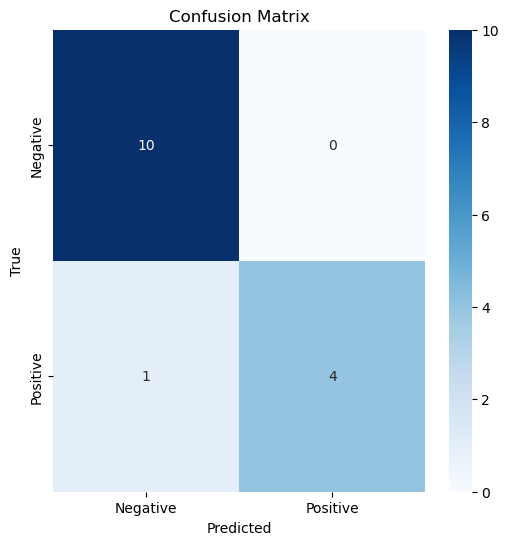

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()